## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_rpg_dataset import XRayDataSet_windows
from src.data.my_rpg_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch

In [2]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [51]:
def get_model_instance_segmentation(num_classes):
      
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [52]:
model = get_model_instance_segmentation(3)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Real try of the Model

In [5]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [6]:
#keep only predictions with score higher than the threshold
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [5]:
#load train data
train_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/pickle_data'))
training_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=collate_fn)

#load validation data
validation_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/validation_pickles'))
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

#load test data
test_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

## Model Testing

In [2]:
#load test data
test_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

In [53]:
#load the model state

model = get_model_instance_segmentation(3)
best_model = torch.load(f'../models/CNN_batch_32.pt',map_location=torch.device('cpu'))
model.load_state_dict(best_model['model_state_dict'])


<All keys matched successfully>

In [9]:
best_model['best_loss']

0.9506131995506766

In [10]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img,cmap='gray')
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].detach().numpy()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [11]:
import numpy as np
from torchvision.ops import box_iou

score_threshold = 0.7
iou_threshold = 0.5

In [26]:
print('----------------------Model evaluation started--------------------------')

device = next(model.parameters()).device
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
    
        images =list(img for img in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
            
        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes'].detach().cpu()
            scores = output['scores'].detach().cpu().numpy()
            labels = output['labels'].detach().cpu().numpy()
            target_boxes = targets[i]['boxes'].cpu()
            target_labels = targets[i]['labels'].cpu().numpy()
            total += target_labels.size
            for box, score, label in zip(boxes, scores, labels):
                if label in target_labels:
                    index = np.where(target_labels == label)[0][0]
                    if score > score_threshold and box_iou(box.unsqueeze(0), target_boxes[index].unsqueeze(0)) > iou_threshold:
                        correct += 1

accuracy = 100 * correct / total

print('----------------------train ended--------------------------')
print('The total model accuracy in the test set was: ', accuracy)
        

----------------------Model evaluation started--------------------------


100%|██████████| 14/14 [01:00<00:00,  4.34s/it]

----------------------train ended--------------------------
The total model accuracy in the test set was:  80.0


In [7]:
iteration =  iter(test_dataloader)

In [8]:
model.eval()
images , targets = next(iteration)
imgs = list(img for img in images)
predictions = model(imgs)

In [17]:
def display_image(image, target):
    to_img = torchvision.transforms.ToPILImage()
    canvas = image.clone().detach()
    for box in target["boxes"]:
        x0, y0, x1, y1 = box
        canvas[:, int(y0), :] = 1
        canvas[:, int(y1), :] = 1
        canvas[:, :, int(x0)] = 1
        canvas[:, :, int(x1)] = 1

    img = to_img(canvas)
    
    print(target)
    display(img.reduce(2))

{'boxes': tensor([[ 520., 1034.,  552., 1070.],
        [ 321.,  575.,  404.,  654.]]), 'labels': tensor([2, 1]), 'image_id': tensor([7]), 'area': tensor([1152, 6557])}


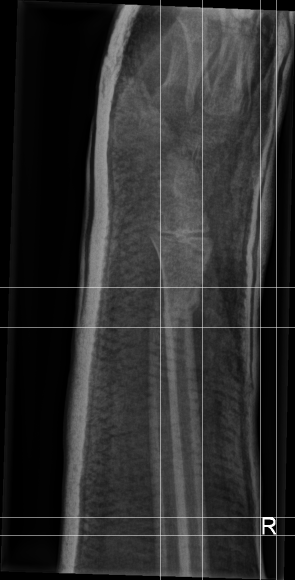

In [18]:
display_image(images[0],targets[0])

In [14]:
images[0].shape

torch.Size([3, 1160, 590])

In [9]:
targets

({'boxes': tensor([[ 520., 1034.,  552., 1070.],
          [ 321.,  575.,  404.,  654.]]),
  'labels': tensor([2, 1]),
  'image_id': tensor([7]),
  'area': tensor([1152, 6557])},)

In [47]:
predictions

[{'boxes': tensor([[227.7587, 295.0671, 295.8968, 337.6314],
          [  9.9080,  22.4320,  22.7109,  41.8668],
          [134.9700, 268.2976, 203.7942, 315.6942],
          [139.9258, 286.4502, 201.1203, 323.2520],
          [229.4485, 295.0289, 296.7518, 383.9970],
          [  9.1170,  21.1920,  30.6624,  45.9884]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 2, 1, 1, 1, 2]),
  'scores': tensor([0.9957, 0.9882, 0.9867, 0.0681, 0.0640, 0.0595],
         grad_fn=<IndexBackward0>)}]

Target :  tensor([1, 2])


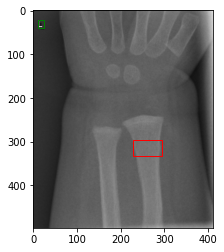

In [48]:
print("Target : ",targets[0]['labels'])
plot_image_from_output(images[0], targets[0])

Prediction :  tensor([1, 2, 1, 1, 1, 2])


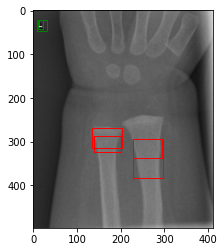

In [49]:
print("Prediction : ", predictions[0]['labels'])
plot_image_from_output(images[0],predictions[0])

In [41]:
import torch
import pickle
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


# Load the pickled object
filename = "../losses.pickle"
with open(filename, 'rb') as f:
    data = CPU_Unpickler(f).load()





In [42]:
data = [t.cpu().detach().numpy() for t in data[0]]


In [36]:
len(data)

200

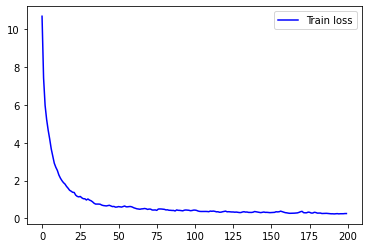

In [43]:
epochs = 200

#plot validation loss over training
plt.plot(list(range(0,epochs)), data, color='blue', label='Train loss')
#plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

## Try to evaluate my dataset with cocoeval 

In [54]:
import torch
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from src.data.my_rpg_dataset import CocoDetection
from src.data.my_rpg_dataset import collate_fn_COCO
from src.data.my_rpg_dataset import XRayDataSet_coco

# Create a dictionary to hold the converted annotations
coco_annotations = {
    'images': [],
    'annotations': [],
    'categories': [{'id': 1, 'name': 'fracture'}, {'id': 2, 'name': 'text'}]
}

#load test data
test_dataset = XRayDataSet_coco(pathlib.Path('../literature/Other/supervisely/wrist/test'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)


# Convert your annotations to COCO format
for i, (img_path, targets) in enumerate(test_dataset):
    
    
    file_name = img_path
    

    # Load the image using cv2
    image = cv2.imread(img_path)

    # Get the height and width of the image
    height, width, channels = image.shape

    coco_annotations['images'].append({
        'id': targets['image_id'].cpu().numpy()[0],
        'file_name': file_name.replace("\\","/").replace('../', ''),
        'height': height,
        'width': width
    })
    for j in range(len(targets['boxes'])):
        #turn boxex from xmin,ymin,xmax,ymax format to coco format x,y,w,h
        box = targets['boxes'][j]
        x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1] 
        area = (box[3] - box[1]) * (box[2] - box[0])
        coco_annotations['annotations'].append({
            'id': len(coco_annotations['annotations']) + 1,
            'image_id': targets['image_id'].cpu().numpy()[0],
            'category_id': targets['labels'][j].item(),
            'bbox': [x.item(), y.item(), w.item(), h.item()],
            'area': area.item(),
            'iscrowd': 0  # Assuming all instances are not crowd
        })

# Create a COCO object for your annotations
coco_gt = COCO()
coco_gt.dataset = coco_annotations
coco_gt.createIndex()

# Create a COCOeval object
#coco_eval = COCOeval(coco_gt, iouType='bbox')


creating index...
index created!


In [ ]:
coco_annotations

In [ ]:
# Save the COCO dataset as a JSON file
with open('coco_test_dataset.json', 'w') as f:
    json.dump(coco_gt.dataset, f)

In [ ]:
# Run evaluation on your model
from torchvision.ops import nms

model.eval()
results = []
confidence=0.7
#load test data
test_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/test'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu()
            scores = output['scores'].cpu()
            labels = output['labels'].cpu()
            image_id = targets[0]['image_id'].cpu().numpy()
            #Apply the NMS function to my boxes
            keep = nms(boxes, scores, iou_threshold=0.5)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]
            for box, score, label in zip(boxes, scores, labels):
                if score > confidence :
                    results.append({
                        'image_id': image_id[0].item(),
                        'category_id': label.item(),
                        'bbox': [box[0].item(), box[1].item(), (box[2]-box[0]).item(), (box[3]-box[1]).item()],
                        'score': score.item()
                    })
# Load your model's results into the COCOeval object
coco_dt = coco_gt.loadRes(results)

In [105]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

In [109]:
model.backbone(images[0]).keys()

odict_keys(['0', '1', '2', '3', 'pool'])

In [114]:
model.backbone(images[0])['pool'].shape

torch.Size([1, 256, 14, 9])

In [112]:
# Reshape tensor to 2D array for plotting
image_array = model.backbone(images[0])['0'][0].permute(1, 2, 0).reshape(-1, 256).detach()

# Create plot
fig, ax = plt.subplots(figsize=(9, 14))
ax.imshow(image_array, cmap='gray')
ax.axis('off')

# Show plot
plt.show()

In [67]:
coco_eval = COCOeval(coco_gt,coco_dt, 'bbox')

# Run evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Get the evaluation metrics
metrics = coco_eval.stats

print('Evaluation metrics: AP = {:.4f}, AP50 = {:.4f}, AP75 = {:.4f}, APs = {:.4f}, APm = {:.4f}, APl = {:.4f}'.format(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5]))

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [ ]:
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.607
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
Evaluation metrics: AP = 0.6068, AP50 = 0.9012, AP75 = 0.6418, APs = 0.5557, APm = 0.6932, APl = 0.6398

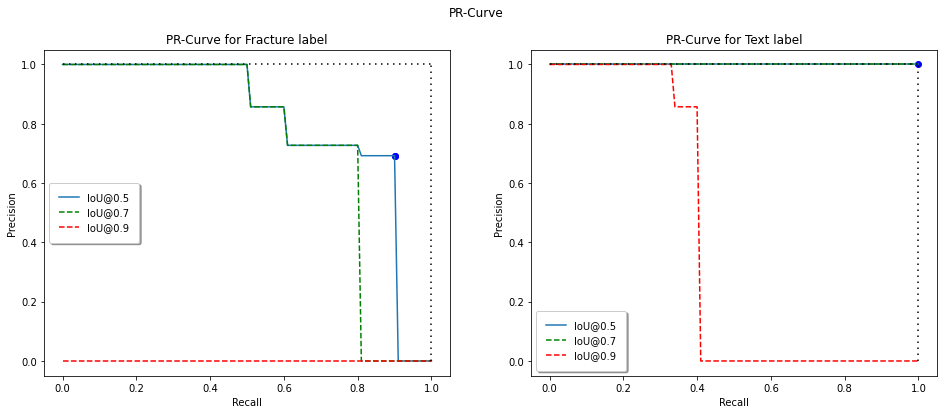

In [114]:
import numpy as np
import matplotlib.pyplot as plt 

all_precision = coco_eval.eval['precision']

pr_5 = all_precision[0, :, 0, 0, 2] # data for IoU@0.5
pr_7 = all_precision[4, :, 0, 0, 2] # data for IoU@0.7
pr_9 = all_precision[8, :, 0, 0, 2] # data for IoU@0.9

x = np.arange(0, 1.01, 0.01)

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot(x, pr_5, label='IoU@0.5')
plt.plot(x, pr_7, '--g',label='IoU@0.7')
plt.plot(x, pr_9, '--r',label='IoU@0.9')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.plot([0,1],  [1,1], linestyle='dashed', dashes=(1,3),color='black')
plt.plot([1,1],  [0,1], linestyle='dashed', dashes=(1,3),color='black')
plt.scatter(coco_eval.eval['recall'][0][0][0][2], coco_eval.eval['precision'][0][int(coco_eval.eval['recall'][0][0][0][2]*100)][0][0][2], label = "Best Trade-off",color = "blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-Curve for Fracture label")

pr_5 = all_precision[0, :, 1, 0, 2] # data for IoU@0.5
pr_7 = all_precision[4, :, 1, 0, 2] # data for IoU@0.7
pr_9 = all_precision[8, :, 1, 0, 2] # data for IoU@0.9

plt.subplot(1, 2, 2)
plt.plot(x, pr_5, label='IoU@0.5')
plt.plot(x, pr_7, '--g',label='IoU@0.7')
plt.plot(x, pr_9, '--r',label='IoU@0.9')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.plot([0,1],  [1,1], linestyle='dashed', dashes=(1,3),color='black')
plt.plot([1,1],  [0,1], linestyle='dashed', dashes=(1,3),color='black')
plt.scatter(coco_eval.eval['recall'][0][1][0][2], coco_eval.eval['precision'][0][int(coco_eval.eval['recall'][0][1][0][2]*100)][1][0][2], label = "Best Trade-off",color = "blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-Curve for Text label")

plt.suptitle("PR-Curve")
plt.show()

In [106]:
f = (coco_eval.eval['recall'][0][0][0][2]*100)
t = (coco_eval.eval['recall'][0][1][0][2]*100)
print("Secondary Evaluation Metrics :\n The AP value on IoU = 0.5 that matters the most is : {:.4f}.\n The Recall of the model for Text label is : {:.4f}. The Precision of the model for Text is : {:.4f}.\n The Recall of the model for Fracture label is : {:.4f}. The Precision of the model for Fracture is : {:.4f}".format(metrics[1], coco_eval.eval['recall'][0][1][0][2], coco_eval.eval['precision'][0][int(t)][1][0][2], coco_eval.eval['recall'][0][0][0][2], coco_eval.eval['precision'][0][int(f)][0][0][2] ))

Secondary Evaluation Metrics :
 The AP value on IoU = 0.5 that matters the most is : 0.9012.
 The Recall of the model for Text label is : 1.0000. The Precision of the model for Text is : 1.0000.
 The Recall of the model for Fracture label is : 0.9000. The Precision of the model for Fracture is : 0.6923


In [191]:
import contextlib
import io

id2label = id2label={2:"text",1:"fracture"}
print('---Per-Class Eval---')
for catId in coco_gt.getCatIds():
    
    coco_eval.params.catIds = [catId]
    
    # Redirect standard output to a null device
    with contextlib.redirect_stdout(io.StringIO()):
        # Call the summarize() function
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
    # Get the evaluation metrics
    metrics = coco_eval.stats
    print("The AP value on IoU = 0.5 for class {} is : {:.4f}.\n".format(id2label[catId],metrics[1]))

---Per-Class Eval---
The AP value on IoU = 0.5 for class fracture is : 0.8024.

The AP value on IoU = 0.5 for class text is : 1.0000.



In [172]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes,target_labels,target_boxes,confidence):
    fig = plt.figure(figsize=(15,10))

    fig.add_subplot(1, 2, 1)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    id2label = id2label={2:"text",1:"fracture"}
    for label, (xmin, ymin, xmax, ymax),c  in zip(target_labels.tolist(), target_boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}'
        ax.text(xmin, ymin, text, fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("Target Image and Boxes")
    ########################################################################################################
    fig.add_subplot(1, 2, 2)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    id2label = id2label={2:"text",1:"fracture"}
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        if score >= confidence:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("Model prediction")


    plt.show()

In [ ]:
iteration =  iter(test_dataloader)

In [168]:

model.eval()
images , targets = next(iteration)
imgs = list(img for img in images)
predictions = model(imgs)

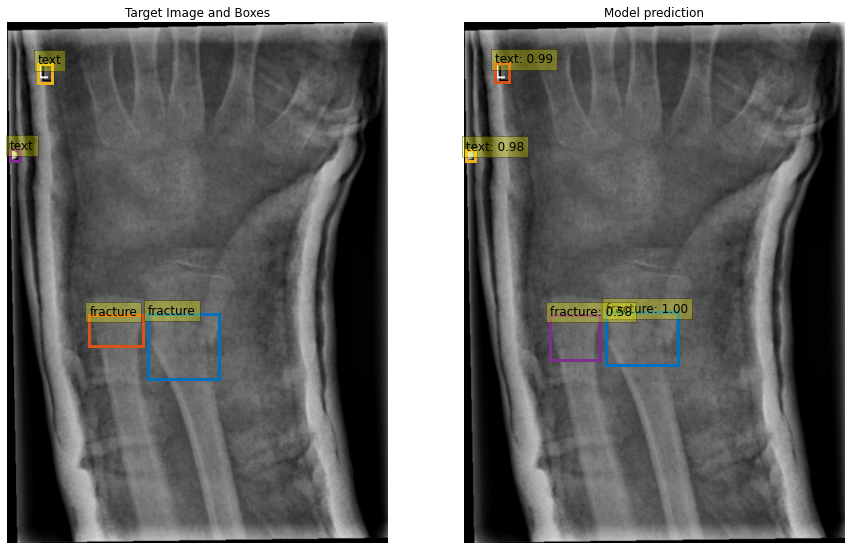

In [173]:
plot_results(images[0].cpu().permute(1,2,0), predictions[0]['scores'], predictions[0]['labels'], predictions[0]['boxes'],targets[0]['labels'], targets[0]['boxes'],confidence=0.5)

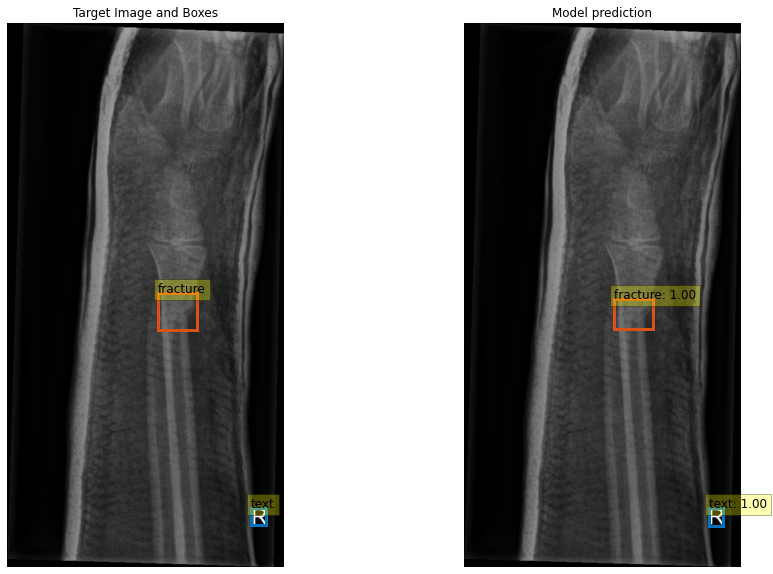

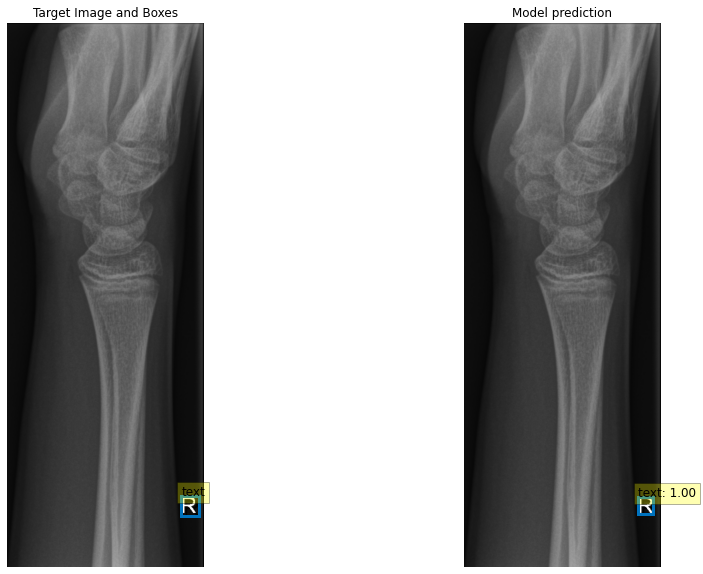

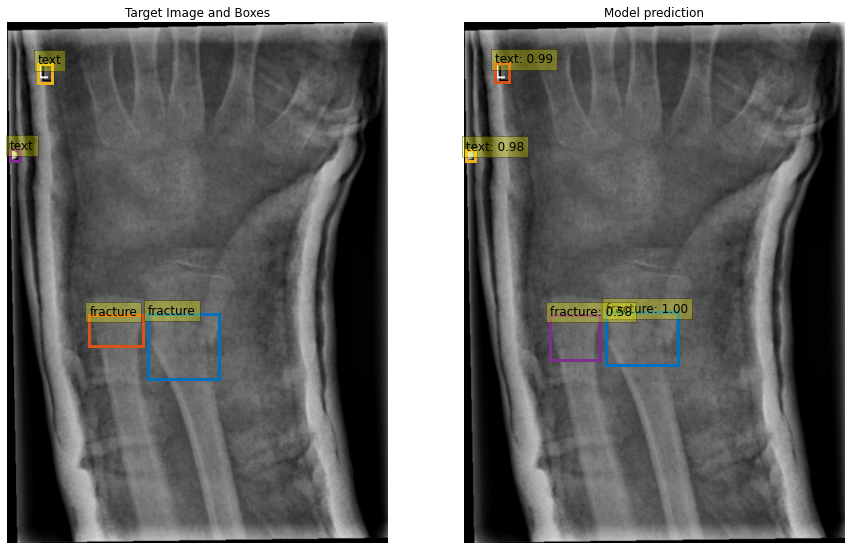

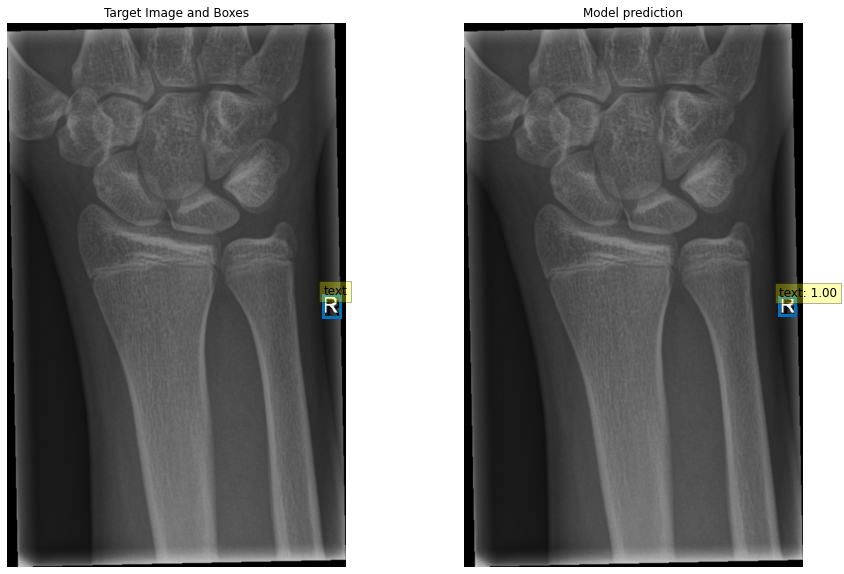

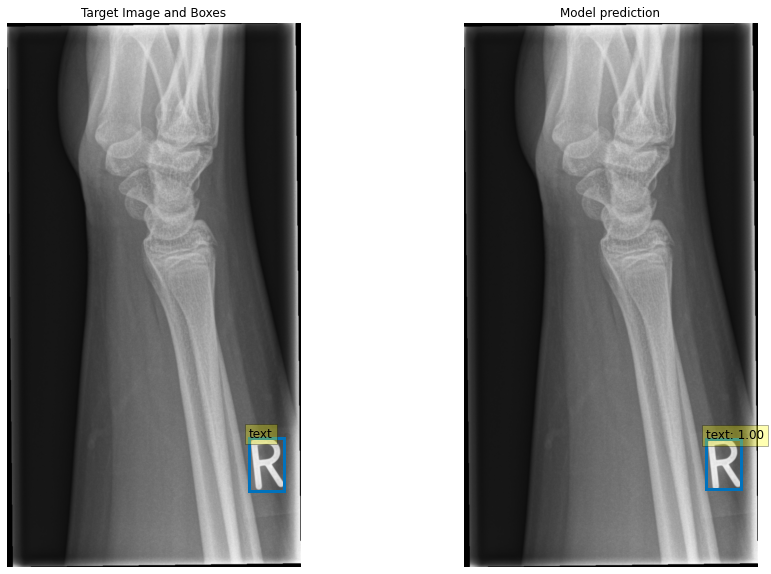

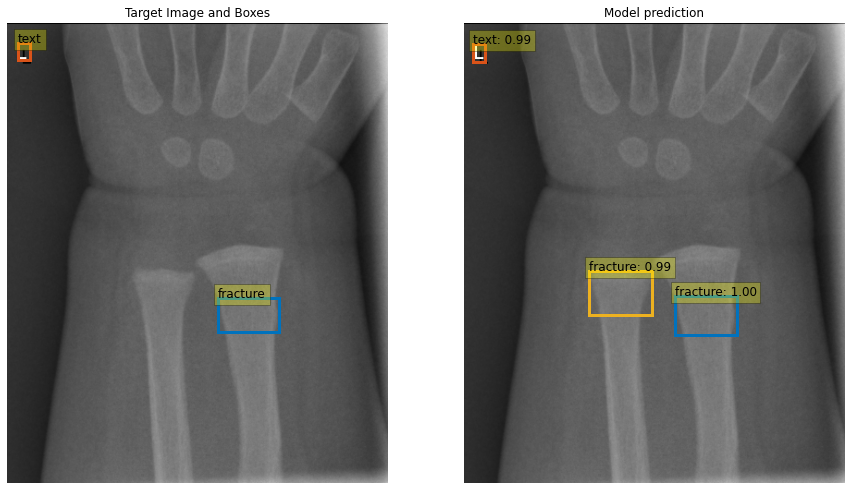

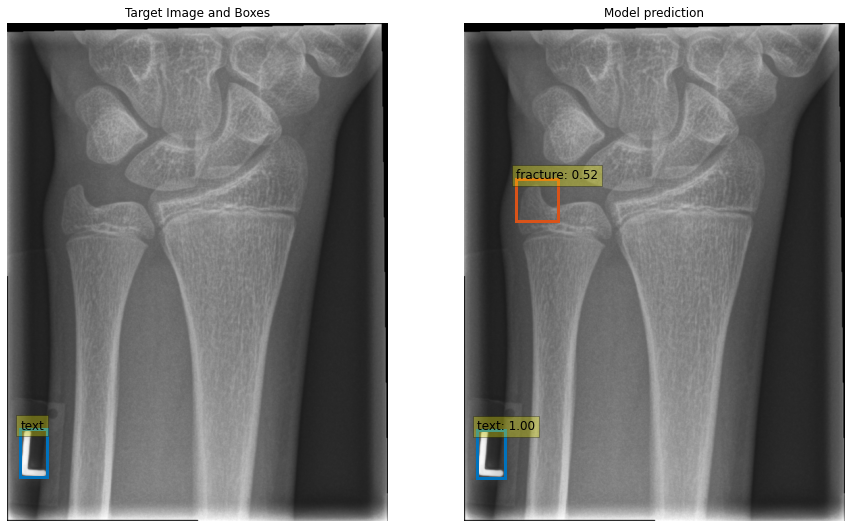

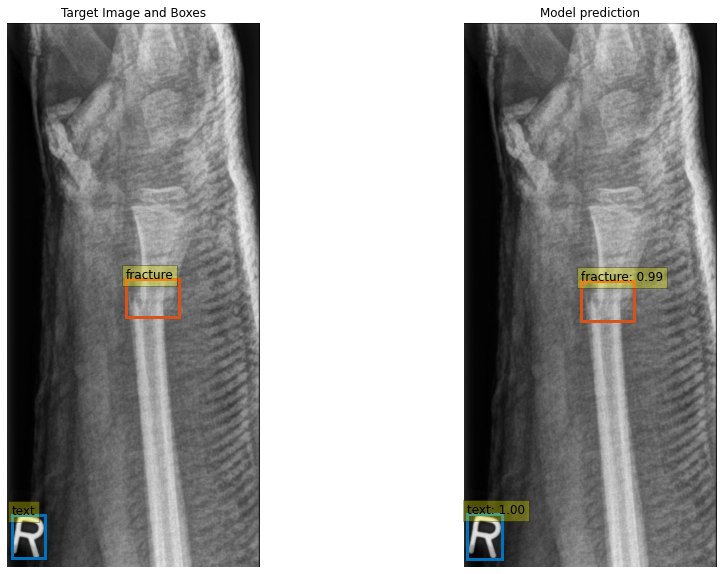

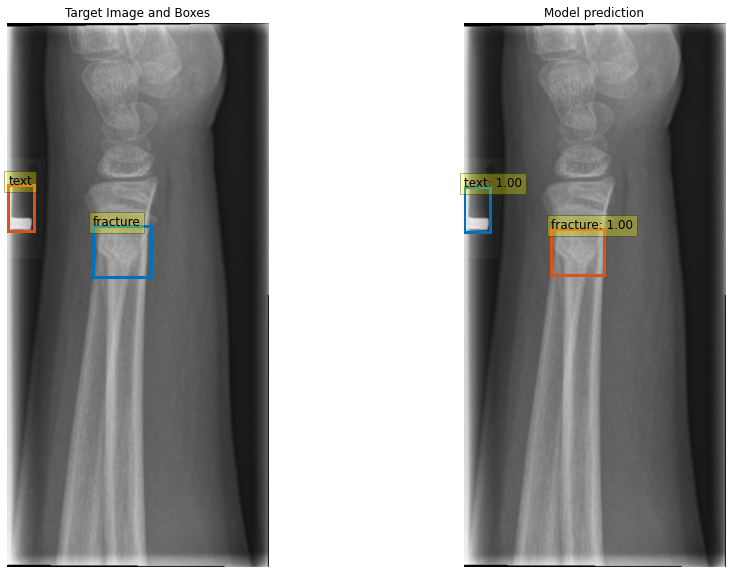

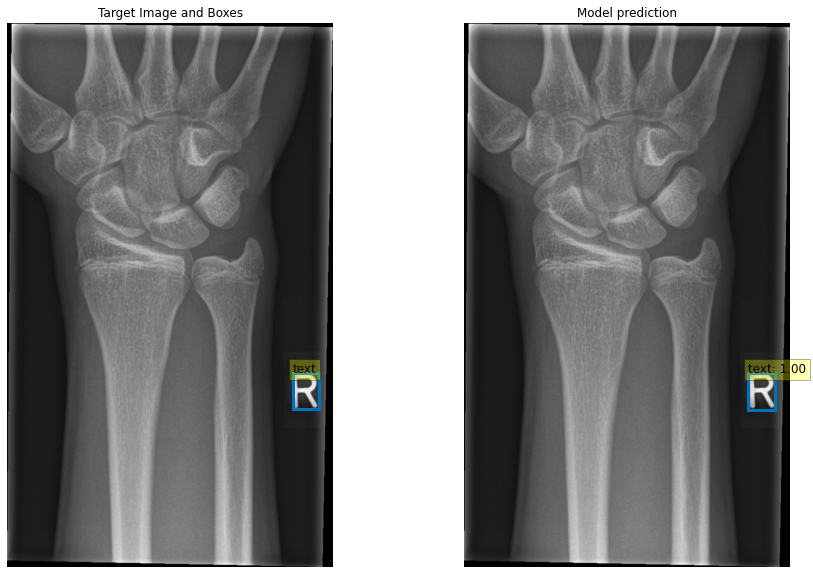

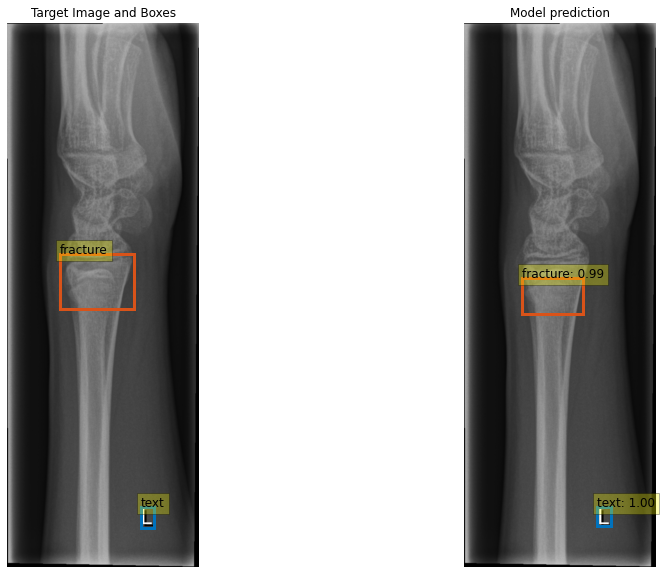

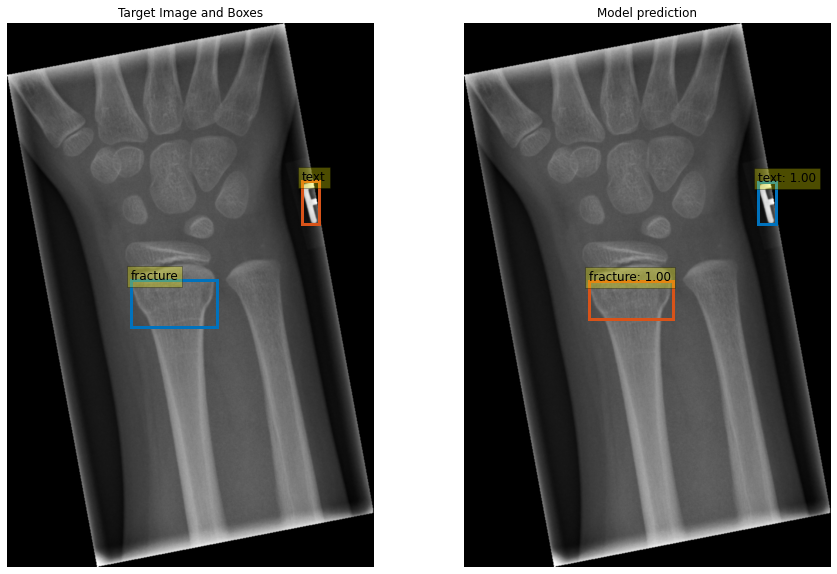

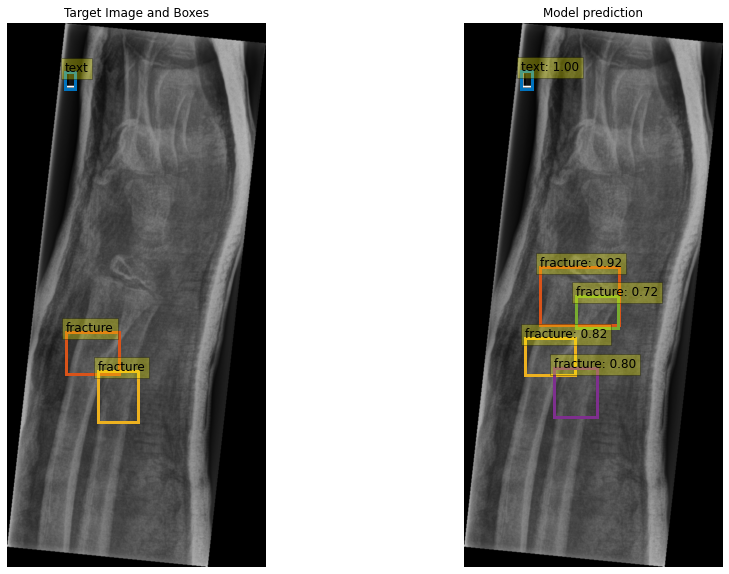

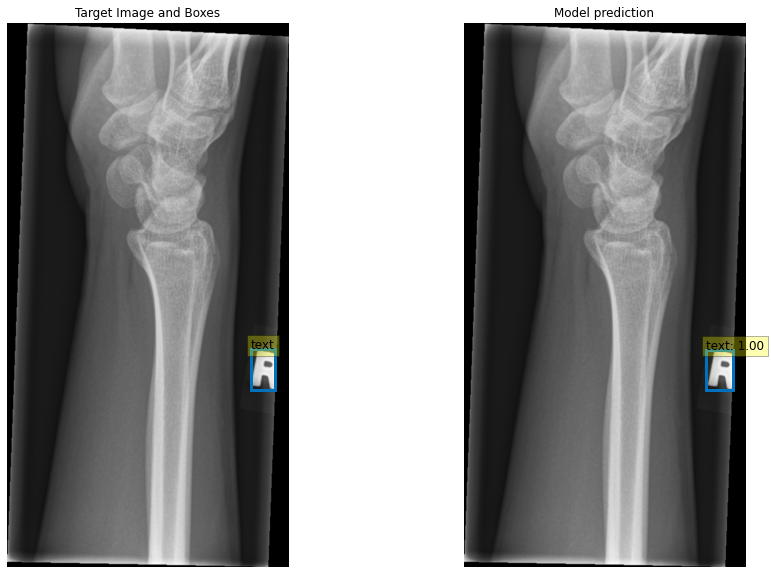

In [192]:
# Set the model to evaluation mode
model.eval()

# Iterate over all batches in the test loader
for batch_idx, (images, targets) in enumerate(test_dataloader):

    # Get the predictions for the batch of images
    predictions = model(images)

    # Iterate over all images in the batch
    for idx in range(len(images)):
        
        # Get the image, predicted scores, labels and boxes for the current image
        img = images[idx].cpu().permute(1, 2, 0)
        scores = predictions[idx]['scores']
        labels = predictions[idx]['labels']
        boxes = predictions[idx]['boxes']

        # Get the ground truth labels and boxes for the current image
        gt_labels = targets[idx]['labels']
        gt_boxes = targets[idx]['boxes']

        # Call your plotting function for the current image
        plot_results(img, scores, labels, boxes, gt_labels, gt_boxes, confidence=0.5)


In [193]:
1

1

test


In [37]:
iteration =  iter(test_dataloader)

In [38]:

images , targets = next(iteration)
imgs = list(img for img in images)

In [39]:
image1 = imgs

In [40]:
images , targets = next(iteration)
imgs = list(img for img in images)

In [41]:
image2 = imgs

In [42]:
images , targets = next(iteration)
imgs = list(img for img in images)

In [43]:
img3 = imgs[0]

In [45]:
# Concatenate the images along the horizontal dimension (dim=3)
import torch.nn.functional as F
img1 = image1[0]
img2 = image2[0]

# Resize the smaller image tensors to match the dimensions of the largest tensor
if img1.shape[1:] != img2.shape[1:]:
    img1 = F.interpolate(img1.unsqueeze(0), size=img2.shape[1:], mode='nearest').squeeze(0)
if img1.shape[1:] != img3.shape[1:]:
    img1 = F.interpolate(img1.unsqueeze(0), size=img3.shape[1:], mode='nearest').squeeze(0)
if img2.shape[1:] != img3.shape[1:]:
    img2 = F.interpolate(img2.unsqueeze(0), size=img3.shape[1:], mode='nearest').squeeze(0)


combined_imgs = torch.cat((img1, img2,img3), dim=2)



In [50]:
comp = torch.cat((img1, img2), dim=2)
comp = torch.cat((comp, img3), dim=2)

In [18]:
image1[0].shape

torch.Size([3, 1160, 590])

In [46]:
combined_imgs.shape

torch.Size([3, 814, 1785])

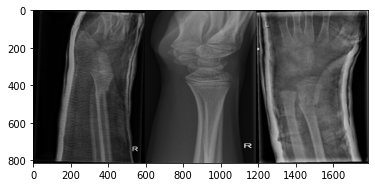

In [47]:
# Convert the combined image tensor to a numpy array
import numpy as np
import matplotlib.pyplot as plt
combined_img_np = combined_imgs.cpu().numpy()

# Transpose the numpy array to match the channel-last format required by matplotlib
combined_img_np = np.transpose(combined_img_np, (1, 2, 0))

# Display the combined image using matplotlib
plt.imshow(combined_img_np)
plt.show()